In [ ]:
%env WORKDIR=/tmp/vault
%env CERT_NAME=2023

In [ ]:
%%bash
cat $WORKDIR/VAULT_TOKEN.TXT
cat $WORKDIR/VAULT_ADDR.TXT

In [ ]:
%env VAULT_ADDR=https://vault-primary-europe-southwest1-jlhb.josemerchan-f986bf.gcp.sbx.hashicorpdemo.com:8200
%env VAULT_TOKEN=hvs.QbtInWOOYqrZJnMrDmcaArKs

## https://developer.hashicorp.com/vault/tutorials/secrets-management/pki-engine

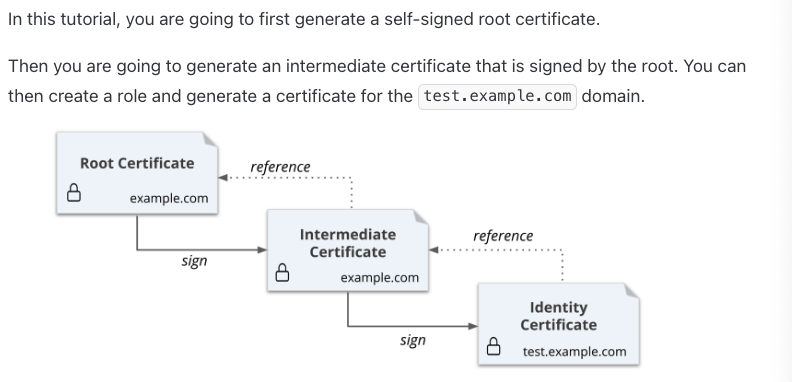

In [ ]:
%%bash

vault secrets list

In [ ]:
%%bash
curl --header "X-Vault-Token: $VAULT_TOKEN" --request POST --data '{"hmac":false}' $VAULT_ADDR/v1/sys/config/auditing/request-headers/my-header


## Step 1: Generate root CA

In [ ]:
%%bash
# Enable PKI
vault secrets enable pki 

In [ ]:
# Tune PKI to set max_tll
! vault secrets tune -max-lease-ttl=87600h pki

In [ ]:
%%bash
# Generate rootCA (this command does not produce any output stdout)
vault write -field=certificate pki/root/generate/internal \
     common_name="example.com" alt_names="test.com" \
     issuer_name="root-$CERT_NAME" \
     ttl=87600h > ${WORKDIR}/root_$CERT_NAME_ca.crt

In [ ]:
%%bash
# List CA information
export ISSUER=$(vault list -format=json pki/issuers/ | jq -r .[0])
echo $ISSUER

vault read pki/issuer/$ISSUER | tail -n 11

[PKI Role](https://developer.hashicorp.com/vault/api-docs/secret/pki#create-update-role) details

In [ ]:
%%bash
# Create a role that will allow for using certificates (in this case any name will be valid)
vault write pki/roles/$CERT_NAME-servers allow_any_name=true

In [ ]:
%%bash
# Configure CA and CRL URLs
vault write pki/config/urls \
     issuing_certificates="$VAULT_ADDR/v1/pki/ca" \
     crl_distribution_points="$VAULT_ADDR/v1/pki/crl" \

[OCSP](https://developer.hashicorp.com/vault/api-docs/secret/pki#ocsp-request)

## Step 2: Generate intermediate CA

In [ ]:
%%bash
# the intermediate CA is expressed a another PKI engine with a separate mount point
vault secrets enable -path=pki_int pki

In [ ]:
# the mount is configured with a max_tll
! vault secrets tune -max-lease-ttl=43800h pki_int

In [ ]:
%%bash
# Generate Intermediate CA whose CSR is going to be signed by the root CA at pki mount path
vault write -format=json pki_int/intermediate/generate/internal \
     common_name="example.com Intermediate Authority" \
     issuer_name="example-dot-com-intermediate" \
     | jq -r '.data.csr' > pki_intermediate.csr

In [ ]:
%%bash
# Send intermediate CA CSR for signing
vault write -format=json pki/root/sign-intermediate \
     issuer_ref="root-$CERT_NAME" \
     csr=@pki_intermediate.csr \
     format=pem_bundle ttl="43800h" \
     | jq -r '.data.certificate' > ${WORKDIR}/intermediate.cert.pem

In [ ]:
# Import signed intermediate CA to its correspondant mount point
! vault write pki_int/intermediate/set-signed certificate=@${WORKDIR}/intermediate.cert.pem

In [ ]:
%%bash
vault write pki_int/config/urls \
     issuing_certificates="$VAULT_ADDR/v1/pki_int/ca" \
     crl_distribution_points="$VAULT_ADDR/v1/pki_int/crl"

## Step 3: Create role -> https://developer.hashicorp.com/vault/tutorials/secrets-management/pki-engine#step-3-create-a-role

In [ ]:
%%bash
# Create role that allow certificates to be signed for domain example.com, internal.com, internal.domain
vault write pki_int/roles/example-dot-com \
     issuer_ref="$(vault read -field=default pki_int/config/issuers)" \
     allowed_domains="example.com","test.com" \
     allow_subdomains=true \
     allow_glob_domains=true \
     allow_wildcard_certificates=true \
     allow_ip_sans=true \
     allowed_uri_sans="*.example.com" \
     max_ttl="24h" \
     ttl="1h" \
     country="ES" locality="Zarautz" province="Gipuzkoa" organization="Hashi" ou="SE"

## Step 4: Requests certificates

In [ ]:
%%bash
#Generate Certificates
#Using Vault CLI
vault write pki_int/issue/example-dot-com common_name="*.test.com" ip_sans="8.8.8.9" uri_sans="otrauri.example.com,masuri.example.com" ttl="1m" 

In [ ]:
%%bash

# Tune to unhash request and response values
vault secrets tune  \
     -max-lease-ttl="43800h"  -audit-non-hmac-request-keys="csr" -audit-non-hmac-request-keys="certificate" -audit-non-hmac-request-keys=issuer_ref -audit-non-hmac-request-keys="common_name" -audit-non-hmac-request-keys=alt_names -audit-non-hmac-request-keys=other_sans  \
     -audit-non-hmac-request-keys="ip_sans" -audit-non-hmac-request-keys=uri_sans  -audit-non-hmac-request-keys=ttl  -audit-non-hmac-request-keys=not_after  \
     -audit-non-hmac-request-keys=serial_number -audit-non-hmac-request-keys=key_type -audit-non-hmac-request-keys=private_key_format \
     -audit-non-hmac-request-keys=ou -audit-non-hmac-request-keys=organization -audit-non-hmac-request-keys=country \
     -audit-non-hmac-request-keys=locality -audit-non-hmac-request-keys=province -audit-non-hmac-request-keys=street_address \
     -audit-non-hmac-request-keys=postal_code -audit-non-hmac-request-keys=permitted_dns_domains -audit-non-hmac-request-keys=policy_identitiers \
     -audit-non-hmac-request-keys=ext_key_usage_oids -audit-non-hmac-response-keys=certificate -audit-non-hmac-response-keys=issuing_ca -audit-non-hmac-response-keys=error  \
     -audit-non-hmac-response-keys=serial_number -audit-non-hmac-response-keys=ca_chain -audit-non-hmac-response-keys=private_key_type -audit-non-hmac-response-keys=expiration pki_int

In [ ]:
%%bash
# Using CURL
# See https://developer.hashicorp.com/vault/api-docs/secret/pki#generate-certificate-and-key
# Example with SANs
curl -k --header "X-Vault-Token: $VAULT_TOKEN" \
    --request PUT --silent\
    --data '{"common_name": "hash123.example.com", "ttl": "2h"}' \
    $VAULT_ADDR/v1/pki_int/issue/example-dot-com | jq

# Examples

In [ ]:
%%bash
export CERT_NAME=san.example.com

# Using CURL
curl -k --header "X-Vault-Token: $VAULT_TOKEN"\
    --request POST --silent \
    --data '{"common_name": "'"$CERT_NAME"'", "ttl": "1m"}' \
    $VAULT_ADDR/v1/pki_int/issue/example-dot-com > ${WORKDIR}/mycert.json

cat ${WORKDIR}/mycert.json | jq -r .data.certificate | openssl x509 -in /dev/stdin -text -noout

In [ ]:
%%bash
export CERT_NAME="test107.test.com"

#Using CURL
curl -k --header "X-Vault-Token: $VAULT_TOKEN"\
    --request POST --silent\
    --data '{"common_name": "'"$CERT_NAME"'", "ttl": "1m"}' \
    $VAULT_ADDR/v1/pki_int/issue/example-dot-com > ${WORKDIR}/mycert.json

cat ${WORKDIR}/mycert.json | jq -r .data.certificate > ${WORKDIR}/mycert_leaf.pem
cat ${WORKDIR}/mycert.json | jq -r .data.private_key > ${WORKDIR}/mycert_key.pem
openssl x509 -in  ${WORKDIR}/mycert_leaf.pem -text -noout

## Read Certificates

In [ ]:
%%bash
# List Certificates

curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys

In [ ]:
%%bash
export SERIAL=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN"\
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[0])
    
# Read Details about a certificate based on serial number
curl -k --silent\
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request GET \
    $VAULT_ADDR/v1/pki_int/cert/$SERIAL | jq -r .data.certificate > ${WORKDIR}/temp.pem
    
openssl x509 -in  ${WORKDIR}/temp.pem -text -noout 

In [ ]:
%%bash
# Revoke certificate based on serial number
# https://developer.hashicorp.com/vault/api-docs/secret/pki#revoke-certificate
export SERIAL=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN" \
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[3])
    
curl -k --silent --header "X-Vault-Token: $VAULT_TOKEN" \
    --request POST \
    --data '{"serial_number": "'"$SERIAL"'"}' \
    $VAULT_ADDR/v1/pki_int/revoke | jq

    

In [ ]:
%%bash
export SERIAL2=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN" \
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[1])

vault write pki_int/revoke serial_number=$SERIAL2



In [ ]:
%%bash
curl --silent  $VAULT_ADDR/v1/pki_int/crl -o $WORKDIR/out.crl
openssl crl -inform DER -text -noout -in $WORKDIR/out.crl



In [ ]:
%%bash
# List Certificates
echo "Todos los certificados"
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys



In [ ]:
%%bash
# https://developer.hashicorp.com/vault/api-docs/secret/pki#tidy
vault write pki_int/tidy tidy_cert_store=true tidy_revoked_certs=true safety_buffer=1m

# Auto Tidy
vault write pki_int/config/auto-tidy tidy_cert_store=true tidy_revoked_certs=true safety_buffer=60m

In [ ]:
%%bash
# List Certificates
echo "Todos los certificados"
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys



## Another example using https://developer.hashicorp.com/vault/tutorials/secrets-management/pki-engine-external-ca

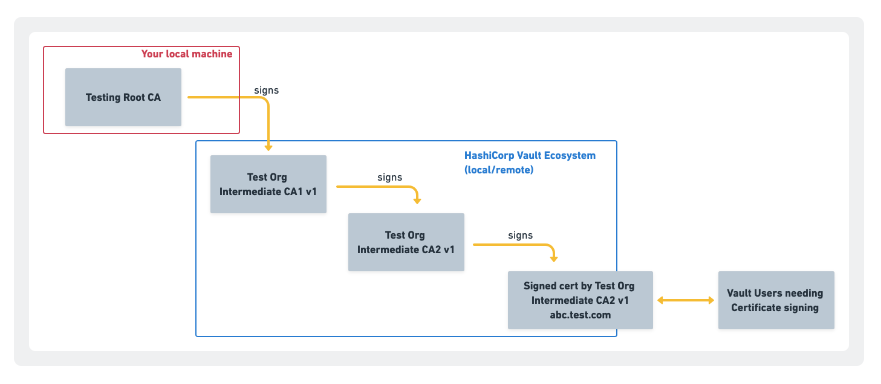

In [ ]:
%%bash
cat > $WORKDIR/main.tf <<EOF
provider "vault" {
}

locals {
 default_3y_in_sec   = 94608000
 default_1y_in_sec   = 31536000
 default_1hr_in_sec = 3600
}
EOF

cat > $WORKDIR/test_org_ica1.tf << EOF
resource "vault_mount" "test_org_v1_ica1_v1" {
 path                      = "test-org/v1/ica1/v1"
 type                      = "pki"
 description               = "PKI engine hosting intermediate CA1 v1 for test org"
 default_lease_ttl_seconds = local.default_1hr_in_sec
 max_lease_ttl_seconds     = local.default_3y_in_sec
}

resource "vault_pki_secret_backend_intermediate_cert_request" "test_org_v1_ica1_v1" {
 depends_on   = [vault_mount.test_org_v1_ica1_v1]
 backend      = vault_mount.test_org_v1_ica1_v1.path
 type         = "internal"
 common_name  = "Intermediate CA1 v1 "
 key_type     = "rsa"
 key_bits     = "2048"
 ou           = "test org"
 organization = "test"
 country      = "US"
 locality     = "Bethesda"
 province     = "MD"
}
EOF

cd $WORKDIR
terraform init
terraform apply -auto-approve

mkdir csr
terraform show -json | jq '.values["root_module"]["resources"][].values.csr' -r | grep -v null > csr/Test_Org_v1_ICA1_v1.csr
 

In [ ]:
%%bash
cat >> $WORKDIR/test_org_ica1.tf << EOF

resource "vault_pki_secret_backend_intermediate_set_signed" "test_org_v1_ica1_v1_signed_cert" {
 depends_on   = [vault_mount.test_org_v1_ica1_v1]
 backend      = vault_mount.test_org_v1_ica1_v1.path

 certificate = file("\${path.module}/cacerts/test_org_v1_ica1_v1.crt")
}

EOF

cd $WORKDIR

terraform apply -auto-approve


In [ ]:
%%bash
curl  -s $VAULT_ADDR/v1/test-org/v1/ica1/v1/ca/pem | openssl crl2pkcs7 -nocrl -certfile  /dev/stdin  | openssl pkcs7 -print_certs -noout

In [ ]:
%%bash
curl -s $VAULT_ADDR/v1/test-org/v1/ica1/v1/ca_chain | openssl crl2pkcs7 -nocrl -certfile  /dev/stdin  | openssl pkcs7 -print_certs -noout

In [ ]:
%%bash
cat > $WORKDIR/test_org_ica2.tf << EOF
resource "vault_mount" "test_org_v1_ica2_v1" {
 path                      = "test-org/v1/ica2/v1"
 type                      = "pki"
 description               = "PKI engine hosting intermediate CA2 v1 for test org"
 default_lease_ttl_seconds = local.default_1hr_in_sec
 max_lease_ttl_seconds     = local.default_1y_in_sec
}

resource "vault_pki_secret_backend_intermediate_cert_request" "test_org_v1_ica2_v1" {
 depends_on   = [vault_mount.test_org_v1_ica2_v1]
 backend      = vault_mount.test_org_v1_ica2_v1.path
 type         = "internal"
 common_name  = "Intermediate CA2 v1 "
 key_type     = "rsa"
 key_bits     = "2048"
 ou           = "test org"
 organization = "test"
 country      = "US"
 locality     = "Bethesda"
 province     = "MD"
}

resource "vault_pki_secret_backend_root_sign_intermediate" "test_org_v1_sign_ica2_v1_by_ica1_v1" {
 depends_on = [
   vault_mount.test_org_v1_ica1_v1,
   vault_pki_secret_backend_intermediate_cert_request.test_org_v1_ica2_v1,
 ]
 backend              = vault_mount.test_org_v1_ica1_v1.path
 csr                  = vault_pki_secret_backend_intermediate_cert_request.test_org_v1_ica2_v1.csr
 common_name          = "Intermediate CA2 v1.1"
 exclude_cn_from_sans = true
 ou                   = "test org"
 organization         = "test"
 country              = "US"
 locality             = "Bethesda"
 province             = "MD"
 max_path_length      = 1  # Limita la cadena de subordinadas a 1, con lo que no puede haber más intermedias
 ttl                  = local.default_1y_in_sec
}

resource "vault_pki_secret_backend_intermediate_set_signed" "test_org_v1_ica2_v1_signed_cert" {
 depends_on  = [vault_pki_secret_backend_root_sign_intermediate.test_org_v1_sign_ica2_v1_by_ica1_v1]
 backend     = vault_mount.test_org_v1_ica2_v1.path
 certificate = format("%s\n%s", vault_pki_secret_backend_root_sign_intermediate.test_org_v1_sign_ica2_v1_by_ica1_v1.certificate, file("\${path.module}/cacerts/test_org_v1_ica1_v1.crt"))
}
EOF

cd $WORKDIR

terraform apply -auto-approve

In [ ]:
%%bash
curl -s $VAULT_ADDR/v1/test-org/v1/ica2/v1/ca/pem | openssl crl2pkcs7 -nocrl -certfile  /dev/stdin  | openssl pkcs7 -print_certs -noout

In [ ]:
%%bash
curl -s $VAULT_ADDR/v1/test-org/v1/ica2/v1/ca_chain | openssl crl2pkcs7 -nocrl -certfile  /dev/stdin  | openssl pkcs7 -print_certs -noout

In [ ]:
%%bash
# pathlen:1
curl -s $VAULT_ADDR/v1/test-org/v1/ica2/v1/ca/pem | openssl x509 -in /dev/stdin -noout -text | grep "X509v3 extensions"  -A 13

In [ ]:
%%bash
# Creamos un role asociado a la última -CA ica2_v1
cat > $WORKDIR/test_org_ica2_role_test_dot_com.tf << EOF
resource "vault_pki_secret_backend_role" "role" {
 backend            = vault_mount.test_org_v1_ica2_v1.path
 name               = "test-dot-com-subdomain"
 ttl                = local.default_1hr_in_sec
 allow_ip_sans      = true
 key_type           = "rsa"
 key_bits           = 2048
 key_usage          = [ "DigitalSignature"]
 allow_any_name     = false
 allow_localhost    = false
 allowed_domains    = ["test.com"]
 allow_bare_domains = false
 allow_subdomains   = true
 server_flag        = false
 client_flag        = true
 no_store           = true
 country            = ["US"]
 locality           = ["Bethesda"]
 province           = ["MD"]
}

EOF

cd $WORKDIR/

terraform apply -auto-approve

In [ ]:
%%bash
vault write -format=json test-org/v1/ica2/v1/issue/test-dot-com-subdomain \
   common_name=1.test.com | jq .data.certificate -r | openssl x509 -in /dev/stdin -text -noout


In [ ]:
%%bash
# https://registry.terraform.io/providers/hashicorp/vault/latest/docs/resources/pki_secret_backend_cert
cat > $WORKDIR/request_cert.tf << EOF
resource "vault_pki_secret_backend_cert" "app" {
  depends_on = [vault_pki_secret_backend_role.role]

  backend = vault_mount.test_org_v1_ica2_v1.path
  name = vault_pki_secret_backend_role.role.name

  common_name = "app.my.test.com"

  ttl = "1h"
}

output "cert" {
  value = vault_pki_secret_backend_cert.app.certificate
}

EOF

cd $WORKDIR/

terraform apply -auto-approve


In [ ]:
%%bash
cat > $WORKDIR/admins.hcl <<EOF
# Manage namespaces

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}


# Manage secrets at 'pki_int'
path "/pki_int/*" {
   capabilities = ["read", "list"]
}

path "pki_int/issue/example-dot-com" {
   capabilities = ["update"]
   
   control_group = {
    factor "authorizer" {
      identity {
        group_names = [ "acct_manager" ]
        approvals = 1
      }
    }
  }
}
path "test-org/v1/ica2/v1/issue/test-dot-com-subdomain" {
   capabilities = ["update"]
}
EOF

vault policy write admins $WORKDIR/admins.hcl


## Clean UP